# Eyesense

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

-Normal (N),
-Diabetes (D),
-Glaucoma (G),
-Cataract (C),
-Age related Macular Degeneration (A),
-Hypertension (H),
-Pathological Myopia (M)

Source: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k/data

In [59]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
from shutil import copy, move

import cv2
from PIL import Image, ImageEnhance

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow import losses
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50

## Dataset analysis

### General information about the data

In [2]:
df = pd.read_csv("/Users/erika/code/caazzi/eyesense/raw_data/ocular-disease-recognition-odir5k/full_df.csv")

In [3]:
df.describe()

,ID,Patient Age,N,D,G,C,A,H,M,O
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2271.150814,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436
std,1417.559018,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,920.750000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2419.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4784.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<br>The dataset has **6392** entries of pictures and diagnosis and **4784** indicating that not all patients have pictures for both eyes.</br>
<br>The ages vary between 1 and 91 years old.</br>

In [4]:
df.sort_values("ID").head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
3194,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",0_left.jpg
3195,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_left.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3196,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3_left.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
3197,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",4_left.jpg
3198,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_left.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

> There are no null values in the DataFrame.

### Data distribution plots

In [6]:
df["Patient Sex"].value_counts()

Patient Sex
Male      3424
Female    2968
Name: count, dtype: int64

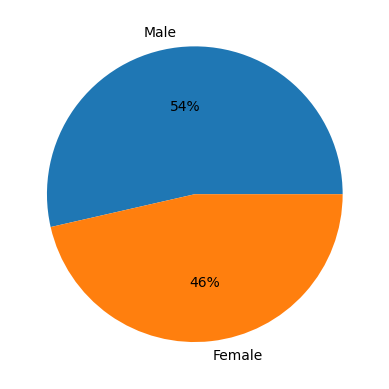

In [7]:
plt.pie(df["Patient Sex"].value_counts(), labels=['Male', 'Female'] ,autopct='%.0f%%')
plt.show()

> The majority of the patients were male.

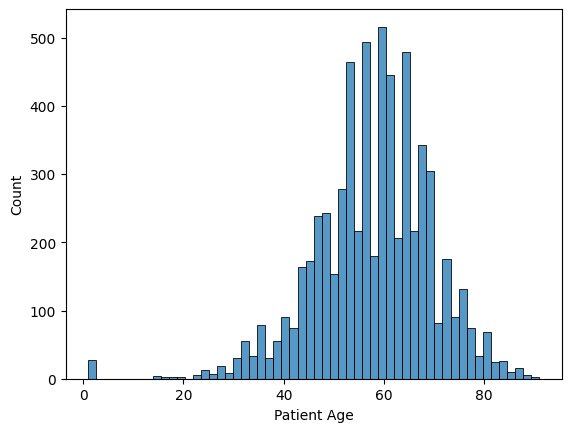

In [8]:
sns.histplot(df["Patient Age"]);

> The patient age was aproximately a normal distribution, centered at ~60 years. There are a few patients of 1 year old.

In [9]:
df['labels'].value_counts()

labels
['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: count, dtype: int64

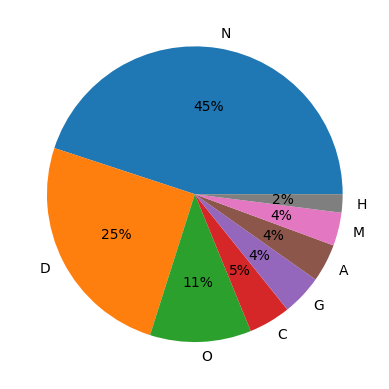

In [10]:
plt.pie(df['labels'].value_counts(), labels=['N', 'D', 'O', 'C', 'G', 'A', 'M', 'H'] ,autopct='%.0f%%')
plt.show()

> The major class is "Normal", thus if our model classifies all the images as "N", our baseline accuracy will be 45%

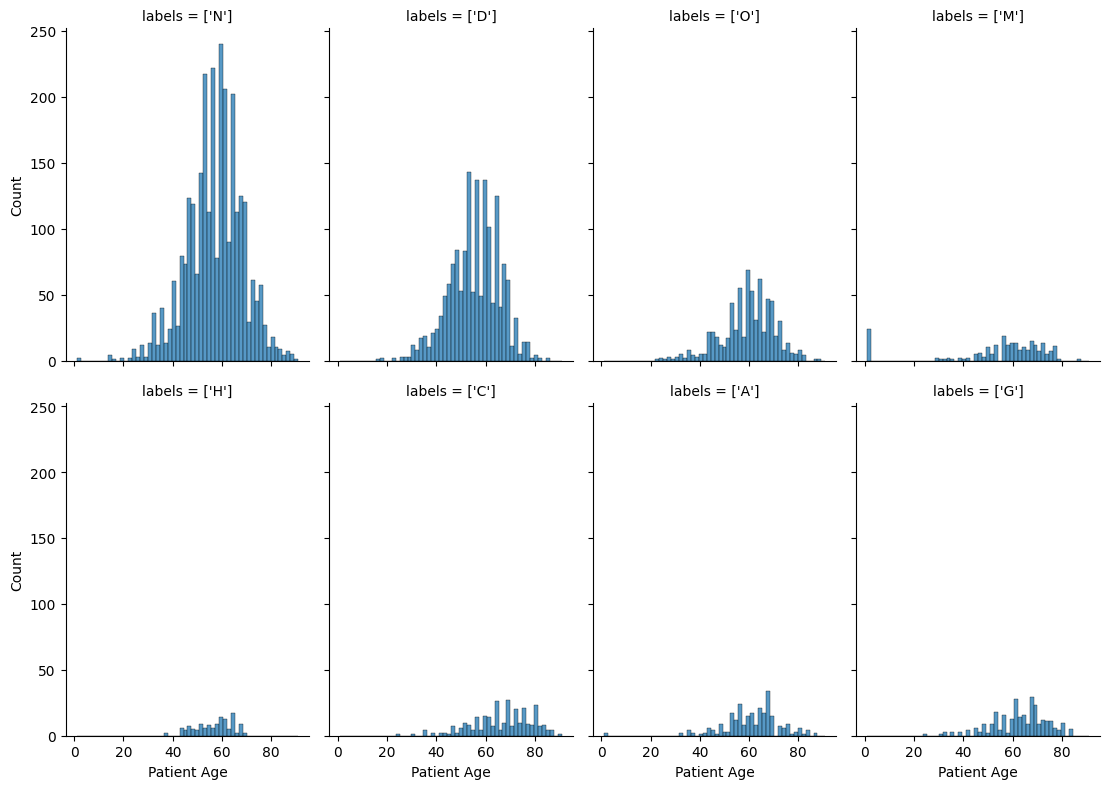

In [11]:
sns.displot(df, x="Patient Age", col="labels", height=4, aspect=.7, col_wrap=4);

In [12]:
df[df['Patient Age'] <= 15].groupby("Patient Age")["labels"].value_counts()

Patient Age  labels
1            ['M']     24
             ['A']      2
             ['N']      2
14           ['N']      2
15           ['N']      2
Name: count, dtype: int64

> The most common diseases in patients with age smaller than 15 is Pathological Myopia (M).

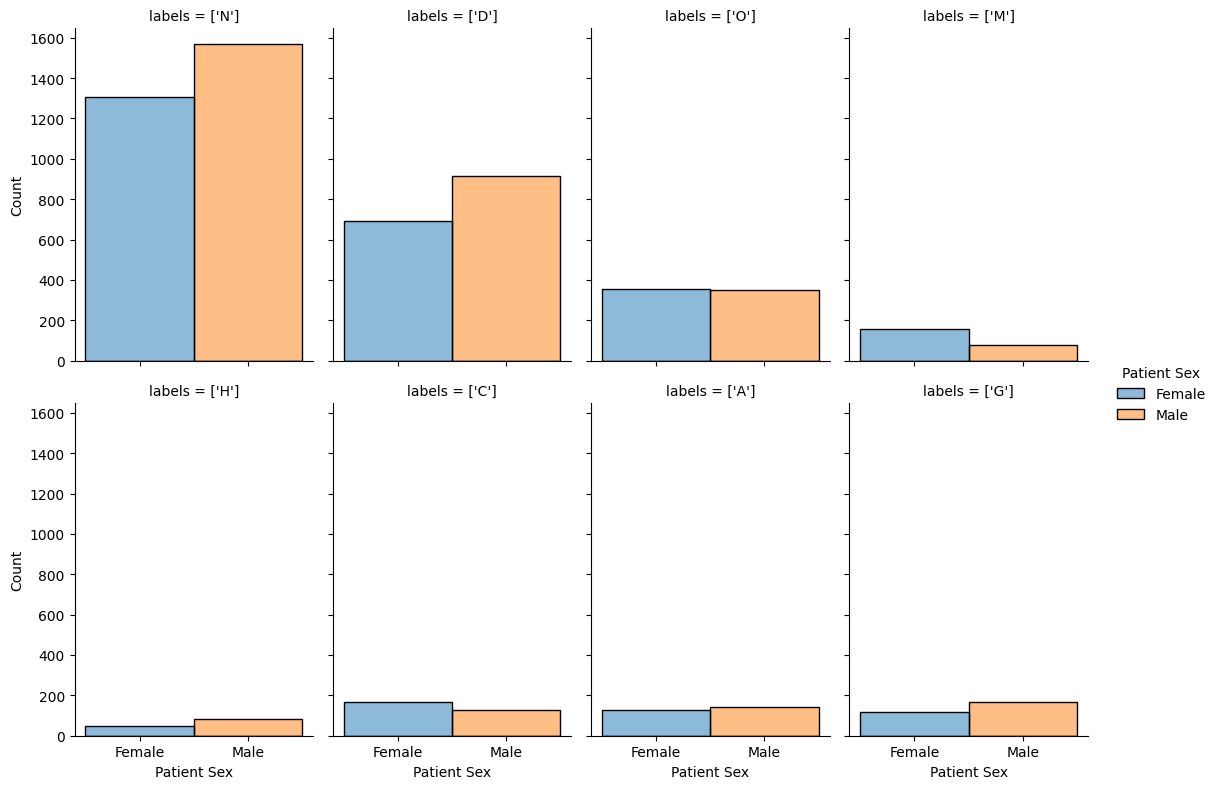

In [13]:
sns.displot(df, x="Patient Sex", col="labels", hue="Patient Sex", height=4, aspect=.7, col_wrap=4)

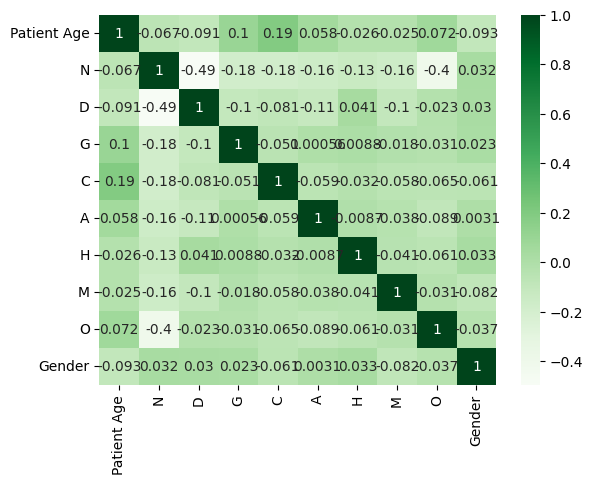

In [14]:
df["Gender"] = LabelEncoder().fit_transform(df["Patient Sex"])

matrix = df.select_dtypes(include=[np.number]).drop(columns='ID').corr()
sns.heatmap(matrix, cmap="Greens", annot=True);
df=df.drop(columns='Gender')

> The biggest correlations found were between the patient's age and Cataract, Glaucoma.

## Images organization and augmentation

### Image organization

In [15]:
# Gets the path to the raw data and creates a list with the image names

dir_path = os.path.join(os.getcwd(), 'raw_data', 'ocular-disease-recognition-odir5k', 'preprocessed_images')
img_list = os.listdir(dir_path)

In [16]:
# Creates the folders necessary to organize the images in different folders according to their classification

if os.path.isdir('data_train/normal') is False:
    os.makedirs('data_train/normal')
    os.makedirs('data_train/diabets')
    os.makedirs('data_train/glaucoma')
    os.makedirs('data_train/cataract')
    os.makedirs('data_train/degeneration')
    os.makedirs('data_train/hypertension')
    os.makedirs('data_train/myopia')
    os.makedirs('data_train/others')

In [17]:
# Creates the folders necessary for test
if os.path.isdir('data_test/normal') is False:
    os.makedirs('data_test/normal')
    os.makedirs('data_test/diabets')
    os.makedirs('data_test/glaucoma')
    os.makedirs('data_test/cataract')
    os.makedirs('data_test/degeneration')
    os.makedirs('data_test/hypertension')
    os.makedirs('data_test/myopia')
    os.makedirs('data_test/others')

In [18]:
if len(os.listdir('data_train/normal')) == 0:  # Check if the directory is empty


    # Copies the training images in the corresponding directory according to the dataframe classification
    
    for file in df.filename[df.labels == "['N']"]:
        copy(os.path.join(dir_path, file) , 'data_train/normal')
    for file in df.filename[df.labels == "['D']"]:
        copy(os.path.join(dir_path, file) , 'data_train/diabets')
    for file in df.filename[df.labels == "['G']"]:
        copy(os.path.join(dir_path, file) , 'data_train/glaucoma')
    for file in df.filename[df.labels == "['C']"]:
        copy(os.path.join(dir_path, file) , 'data_train/cataract')
    for file in df.filename[df.labels == "['A']"]:
        copy(os.path.join(dir_path, file) , 'data_train/degeneration')
    for file in df.filename[df.labels == "['H']"]:
        copy(os.path.join(dir_path, file) , 'data_train/hypertension')
    for file in df.filename[df.labels == "['M']"]:
        copy(os.path.join(dir_path, file) , 'data_train/myopia')
    for file in df.filename[df.labels == "['O']"]:
        copy(os.path.join(dir_path, file) , 'data_train/others')

else:
    print("The directory 'data_train/normal' is not empty")
    print(f"\nProbably the files from {dir_path} were already copied into 'data_train/normal'.")

In [19]:
source_paths = ['data_train/normal', 'data_train/diabets', 'data_train/glaucoma', 'data_train/cataract', 
                'data_train/degeneration', 'data_train/hypertension',
                'data_train/myopia', 'data_train/others']  

if len(os.listdir('data_test/normal')) == 0:
    for source in source_paths:
        dest = source.replace('data_train', 'data_test')
        n_files = int(0.1*len(os.listdir(source)) )   #Taking 10% of each folder
        for file in random.sample(os.listdir(source), n_files): 
            move(f"{source}/{file}", dest)
else:
    print("The directory 'data_test/normal' is not empty")
    print(f"\nProbably the files from {dir_path} were already copied into 'data_test/normal'.")

In [20]:
data_dir_train = os.path.join(os.getcwd(), 'data_train')
data_dir_test = os.path.join(os.getcwd(), 'data_test')

In [21]:
train_length = sum(len([f for f in files if f.endswith('.jpg')]) for _, _, files in os.walk(data_dir_train))
test_length = sum(len([f for f in files if f.endswith('.jpg')]) for _, _, files in os.walk(data_dir_test))
print(f"Train: {train_length}")
print(f"Test:  {test_length}")

Train: 5757
Test:  635


### Image augmentation

In [22]:
def augment_fundus_image(image_path):
    """
    Load a fundus image, apply 8 different augmentations, and save the transformed versions
    with descriptive suffixes.
    
    Args:
        image_path (str): Path to the original fundus image
    """
    # Load the image
    img = Image.open(image_path)
    
    # Get the filename and directory
    img_dir, img_filename = os.path.split(image_path)
    filename, ext = os.path.splitext(img_filename)
    
    # 1. Rotation (±20 degrees)
    angle = random.uniform(-20, 20)
    rotated = img.rotate(angle, resample=Image.BICUBIC, expand=False)
    rotated_path = os.path.join(img_dir, f"{filename}_rot{angle:.1f}{ext}")
    rotated.save(rotated_path)
    
    # 2. Horizontal flip
    flipped_h = img.transpose(Image.FLIP_LEFT_RIGHT)
    flipped_h_path = os.path.join(img_dir, f"{filename}_fliph{ext}")
    flipped_h.save(flipped_h_path)
    
    # 3. Brightness adjustment (+15%)
    brightness_enhancer = ImageEnhance.Brightness(img)
    brightened = brightness_enhancer.enhance(1.15)
    brightened_path = os.path.join(img_dir, f"{filename}_bright+15{ext}")
    brightened.save(brightened_path)
    
    # 4. Brightness adjustment (-15%)
    darkened = brightness_enhancer.enhance(0.85)
    darkened_path = os.path.join(img_dir, f"{filename}_bright-15{ext}")
    darkened.save(darkened_path)
    
    # 5. Contrast adjustment (+15%)
    contrast_enhancer = ImageEnhance.Contrast(img)
    contrast_increased = contrast_enhancer.enhance(1.15)
    contrast_increased_path = os.path.join(img_dir, f"{filename}_contr+15{ext}")
    contrast_increased.save(contrast_increased_path)
    
    # 6. Slight Gaussian blur
    # Convert to numpy array for OpenCV processing
    img_np = np.array(img)
    blurred = cv2.GaussianBlur(img_np, (5, 5), 0)
    blurred_img = Image.fromarray(blurred)
    blurred_path = os.path.join(img_dir, f"{filename}_blur{ext}")
    blurred_img.save(blurred_path)
    
    # 7. Small translation
    width, height = img.size
    x_shift = int(width * 0.05)  # 5% shift
    y_shift = int(height * 0.05)  # 5% shift
    
    # Create a new image with the same size and black background
    translated = Image.new('RGB', (width, height))
    # Paste the original image with an offset
    translated.paste(img, (x_shift, y_shift))
    translated_path = os.path.join(img_dir, f"{filename}_trans{ext}")
    translated.save(translated_path)
    
    # 8. Slight scaling (zoom in 10%)
    scale_factor = 1.1
    
    # Calculate new dimensions
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    
    # Resize image
    scaled = img.resize((new_width, new_height), Image.BICUBIC)
    
    # Crop back to original size (from center)
    left = (new_width - width) // 2
    top = (new_height - height) // 2
    right = left + width
    bottom = top + height
    scaled = scaled.crop((left, top, right, bottom))
    
    scaled_path = os.path.join(img_dir, f"{filename}_zoom10{ext}")
    scaled.save(scaled_path)

In [23]:
dir_list = os.listdir(data_dir_train)
dir_list.remove('normal') # the mais class
dir_list.remove('diabets') # the second class
dir_list.remove('others') # we won't use this class
dir_list

['hypertension', 'cataract', 'glaucoma', 'degeneration', 'myopia']

In [24]:
for i in dir_list:
    i_path = os.path.join(data_dir_train, i)
    
    image_list = os.listdir(i_path)
    image_path = [os.path.join(i_path, x) for x in image_list]
    
    # Apply the augmentation function
    for img in image_path:
        augment_fundus_image(img)
    
    print(f"Processamento de {i} concluído.")

Processamento de hypertension concluído.
Processamento de cataract concluído.
Processamento de glaucoma concluído.
Processamento de degeneration concluído.
Processamento de myopia concluído.


In [26]:
data_length = sum(len([f for f in files if f.endswith('.jpg')]) for _, _, files in os.walk(data_dir_train))

print(f"Final number of images: {data_length}")

Final number of images: 14437


In [27]:
batch_size = 8
img_height = 256
img_width  = 256

In [28]:
train_ds = image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14437 files belonging to 8 classes.
Using 11550 files for training.


In [29]:
val_ds = image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14437 files belonging to 8 classes.
Using 2887 files for validation.


In [30]:
class_names_train = train_ds.class_names
class_names_train

['cataract',
 'degeneration',
 'diabets',
 'glaucoma',
 'hypertension',
 'myopia',
 'normal',
 'others']

In [31]:
class_names_val = val_ds.class_names
class_names_val

['cataract',
 'degeneration',
 'diabets',
 'glaucoma',
 'hypertension',
 'myopia',
 'normal',
 'others']

## PCA

### Check-list

In [32]:
# Main directory for the images
path_augm = "data_train"

# Sets to store the verifications
sizes = set()  # Stores unique sizes of the images
modes = set()  # Stores the color modes (RGB, L, RGBA, etc.)
num_images = 0  # Counts the processed images

# Loops through all subfolders and archives
for root, _, files in os.walk(path_augm):
    for img_name in files:
        img_path = os.path.join(root, img_name)

        try:
            with Image.open(img_path) as img:
                sizes.add(img.size)  # Adiciona tamanho da imagem
                modes.add(img.mode)  # Adiciona modo de cor (ex: 'RGB', 'L')
                num_images += 1
        except Exception as e:
            print(f"Error opening {img_path}: {e}")

# Checks if all images are PCA-compatible
if len(sizes) > 1:
    print(f"🚨 Error: The images have different sizes: {sizes}")
    print("⚠️ All images need to have the same size for PCA.")
else:
    print(f"✅ All images have the same size: {list(sizes)[0]}")

if len(modes) > 1:
    print(f"🚨 Error: The images have different color modes: {modes}")
    print("⚠️ Converting all images to the same format might be necessary (e.g., RGB).")
else:
    print(f"✅ All images are in the same color mode: {list(modes)[0]}")

if num_images < 2:
    print("🚨 Error: Too few images found for PCA. More samples are needed.")
else:
    print(f"✅ Sufficient number of images: {num_images}")

✅ All images have the same size: (512, 512)
✅ All images are in the same color mode: RGB
✅ Sufficient number of images: 14437


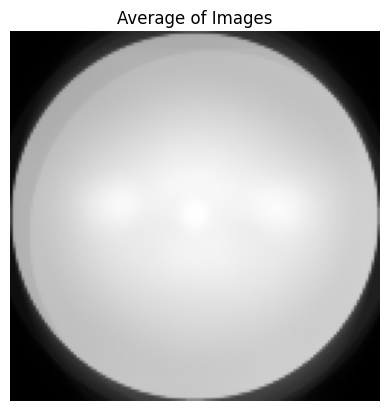

In [33]:
imgs = []

# Loops through all subfolders and files
for root, _, files in os.walk(path_augm):
    for img_name in files:
        img_path = os.path.join(root, img_name)
        
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            if img is None:
                print(f"⚠️ Error loading image: {img_path}")
                continue  # Skip corrupted or incompatible images
            
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size
            imgs.append(img)
        
        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")

# Check if there are any images before calculating the mean
if len(imgs) == 0:
    print("🚨 No valid images found!")
else:
    # Calculate the mean of the images
    mean_img = np.mean(imgs, axis=0)

    # Display the mean image
    plt.imshow(mean_img, cmap='gray')
    plt.title("Average of Images")
    plt.axis("off")
    plt.show()


### Flattening and decomposing

In [34]:
# Lists to store flattened images and labels
X_list = []
y_list = []

# Iterate over the dataset
for batch in train_ds:
    images, labels = batch  # Get the images and labels
    
    images = images.numpy() / 255.0  # Normalize images to [0,1]
    flattened_images = images.reshape(images.shape[0], -1)  # Flatten each image
    
    X_list.append(flattened_images)
    y_list.append(labels.numpy())  # Convert labels to NumPy

# Convert lists to NumPy arrays
X_pca = np.vstack(X_list)  # Matrix of flattened images
y = np.concatenate(y_list)  # Corresponding labels vector

print(f"Shape of X_pca: {X_pca.shape}")  # (N_images, 196608)
print(f"Shape of y: {y.shape}")  # (N_images,)
print(f"Unique classes: {np.unique(y)}")  # Check available classes


2025-03-19 17:08:17.494308: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Shape of X_pca: (11550, 196608)
Shape of y: (11550,)
Unique classes: [0 1 2 3 4 5 6 7]


In [35]:
pca = PCA(n_components=25) 
X_pca_model = pca.fit_transform(X_pca)

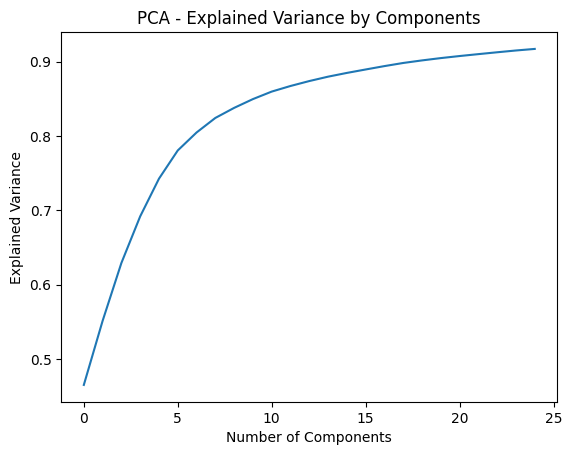

In [36]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("PCA - Explained Variance by Components")

plt.show()

In [37]:
# Lists to store flattened images and labels
X_list = []
y_list = []

# Iterate over the dataset
for batch in val_ds:
    images, labels = batch  # Get the images and labels
    
    images = images.numpy() / 255.0  # Normalize images to [0,1]
    flattened_images = images.reshape(images.shape[0], -1)  # Flatten each image
    
    X_list.append(flattened_images)
    y_list.append(labels.numpy())  # Convert labels to NumPy

# Convert lists to NumPy arrays
X_pca_val = np.vstack(X_list)  # Matrix of flattened images
y_val = np.concatenate(y_list)  # Corresponding labels vector

print(f"Shape of X_pca_val: {X_pca_val.shape}")  # (N_images, 196608)
print(f"Shape of y_val: {y_val.shape}")  # (N_images,)
print(f"Unique classes: {np.unique(y_val)}")  # Check available classes

2025-03-19 17:11:19.587125: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Shape of X_pca_val: (2887, 196608)
Shape of y_val: (2887,)
Unique classes: [0 1 2 3 4 5 6 7]


## Naive model with KNN

### Cross-validate

In [38]:
acc_n = {}
for n in range(1, 101):
    knn = KNeighborsClassifier(n_neighbors=n)
    mean_acc = cross_val_score(knn, X=X_pca_model, y=y, scoring='accuracy', cv=5).mean()
    acc_n[n] = mean_acc

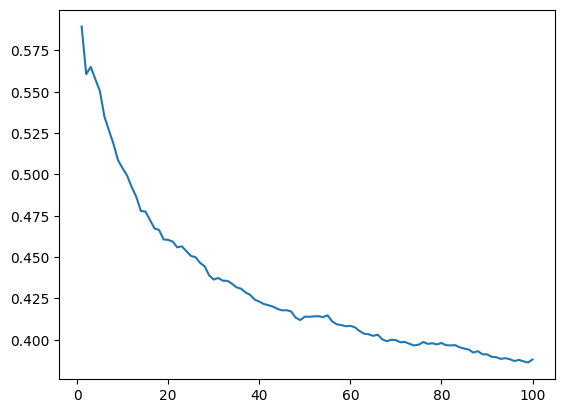

In [39]:
plt.plot(acc_n.keys(), acc_n.values());

### Hold-out

In [40]:
X_pca_model_val = pca.transform(X_pca_val)

In [41]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_pca_model, y)

KNeighborsClassifier(n_neighbors=1)

In [42]:
y_pred = knn.predict(X_pca_model_val)

### Metrics

In [43]:
# Calculate the metrics correctly for multiclass classification
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Show results
print(f"The model's accuracy is: {accuracy}")
print(f"The model's precision is: {precision}")
print(f"The model's recall is: {recall}")
print(f"The F1 score is: {f1}")

The model's accuracy is: 0.5957741600277104
The model's precision is: 0.5933353918684895
The model's recall is: 0.5957741600277104
The F1 score is: 0.5905795250780169


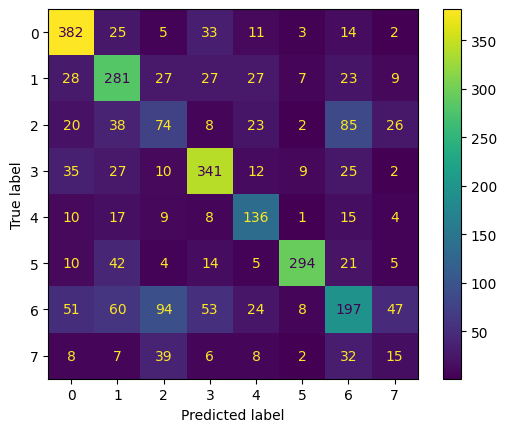

In [44]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

## Naive model with Random Forest Classifier

### Cross-validate

In [45]:
RFClass = RandomForestClassifier()
mean_acc = cross_val_score(RFClass, X=X_pca_model, y=y, scoring='accuracy', cv=5).mean()
mean_acc

np.float64(0.687099567099567)

### Hold-out

In [46]:
RFClass.fit(X_pca_model, y)
y_pred = RFClass.predict(X_pca_model_val)

### Metrics

In [47]:
# Calculate the metrics correctly for multiclass classification
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Show results
print(f"The model's accuracy is: {accuracy}")
print(f"The model's precision is: {precision}")
print(f"The model's recall is: {recall}")
print(f"The F1 score is: {f1}")

The model's accuracy is: 0.7017665396605473
The model's precision is: 0.6974615146077277
The model's recall is: 0.7017665396605473
The F1 score is: 0.6766476300666715


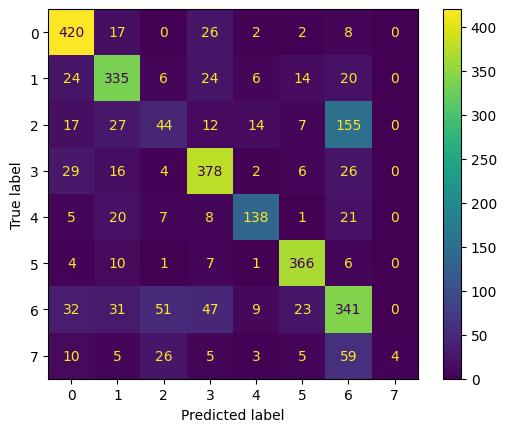

In [48]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

## CNN

In [49]:
def initialize_model():


    model = models.Sequential()
    
    model = tf.keras.Sequential([
          tf.keras.layers.Rescaling(1./255),
          tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(4,4)),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(4,4)),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Conv2D(32, (4,4), activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(4,4)),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(8, activation='softmax')
        ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    ### Model compilation
    model.compile(
          optimizer=optimizer,
          loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
          metrics=['accuracy'])
    
    return model

In [50]:
model = initialize_model()

In [51]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [53]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 50,
    callbacks = [es],
    verbose = 1
)

Epoch 1/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 572s 396ms/step - accuracy: 0.2396 - loss: 1.9317 - val_accuracy: 0.4115 - val_loss: 1.6051
Epoch 2/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 569s 394ms/step - accuracy: 0.3949 - loss: 1.6124 - val_accuracy: 0.5210 - val_loss: 1.3146
Epoch 3/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 545s 377ms/step - accuracy: 0.5188 - loss: 1.2769 - val_accuracy: 0.5726 - val_loss: 1.1271
Epoch 4/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 540s 374ms/step - accuracy: 0.5499 - loss: 1.1727 - val_accuracy: 0.5850 - val_loss: 1.0940
Epoch 5/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 530s 367ms/step - accuracy: 0.5820 - loss: 1.1041 - val_accuracy: 0.5961 - val_loss: 1.0422
Epoch 6/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 536s 371ms/step - accuracy: 0.5895 - loss: 1.0579 - val_accuracy: 0.5989 - val_loss: 1.0445
Epoch 7/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 537s 372ms/step - accuracy: 0.6164 - loss: 0.9857 - val_accuracy: 0.6020 - val_loss: 1.0041
Epoch 8/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 527s 365ms/step - ac

In [54]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.autoscale()
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.autoscale()
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

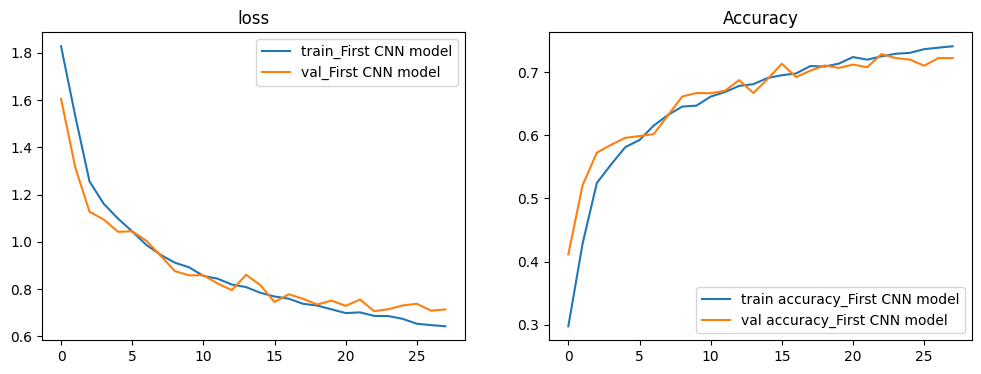

In [55]:
plot_history(history, exp_name= 'First CNN model');

## Resnet

In [68]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the base model
# Add custom layers for your classification task

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
output = layers.Dense(8, activation='softmax')(x)  # the number of your classes

model = models.Model(inputs=base_model.input, outputs=output)

In [69]:
model.compile(
    optimizer= optimizers.Adam(learning_rate=0.001),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [70]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 50,
    callbacks = [es],
    verbose = 1
)

Epoch 1/50
 353/1444 ━━━━━━━━━━━━━━━━━━━━ 11:12 616ms/step - accuracy: 0.4912 - loss: 1.4672